# Further implementation

Reiread the previous articles, and also read the [follow-up](https://blog.otoro.net/2015/07/31/neurogram/) [articles](https://blog.otoro.net/2016/03/25/generating-abstract-patterns-with-tensorflow/). and took a closer look as previous was done after skimming. Learnt about the concept of compositional pattern producing networks (CPPNs for short), which is basically what I'm implementing here. Though I missed a few interesting features, thus implementing them in this notebook. 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import noise
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## Adding bias

Left out adding bias to the inputs. See what's the impact:

In [17]:
class Net(nn.Module):
    """
    Input
    -----
    Normalized (x, y), ranging from -1 to 1
    Output: RGB color at that point.
    """
    def __init__(self, num_hidden_layers=4, num_neurons=8, include_bias=False):
        """
        Inputs
        ------
        num_hidden_layers: int
        num_neurons: int
        include_bias: bool
        """
        super(Net, self).__init__()
        
        # Input layer
        layers = [nn.Linear(2, num_neurons, bias=include_bias), nn.Tanh()]
        
        # Hidden layers
        layers.extend(num_hidden_layers * [nn.Linear(num_neurons, num_neurons, bias=False), nn.Tanh(),])
            
        # Output layer
        layers.extend([nn.Linear(num_neurons, 3, bias=False), nn.Sigmoid()])
        
        # Assign layers to self.layers
        self.layers = nn.Sequential(*layers)
        
        # Run weight init
        self.init_weights()
        
    def forward(self, x):
        x = self.layers(x)
        return x
    
    def _init_weights(self, m):
        """
        Ref: https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
        """
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, mean=0, std=1)
            
    def init_weights(self):
        self.apply(self._init_weights)

In [77]:
def create_input(img_width, img_height):
    """
    Creates the input for the generative net. 
    Outputs numpy array w/ shape (img_width * img_height, 2)
    """
    # Create vectors of xs and ys   
    xs = np.linspace(start=-1, stop=1, num=img_width)
    ys = np.linspace(start=-1, stop=1, num=img_height)
    
    # Use np.meshgrid to create a mesh grid
    xv, yv = np.meshgrid(xs, ys)
    input_arr = np.stack((xv, yv), axis=2)
    input_arr = input_arr.reshape(img_width * img_height, 2)
    return input_arr

In [78]:
def generate_one_art(net, input_config={"img_width":320, "img_height":320}):
    # Create input to net
    net_input = torch.tensor(create_input(**input_config)).float()
    
    # Run input through net
    net_output = net(net_input).detach().numpy()
    
    # Reshape into (x, y, 3) for plotting
    net_output = net_output.reshape(input_config["img_width"], input_config["img_width"], 3)
    
    # Re-format to color output
    # Scale to range 0 to 255, and set type to int
    net_output = (net_output * 255).astype(np.uint8)
    return net_output

In [79]:
def generate_one_gallery(
    net_config={"num_hidden_layers":4, "num_neurons":8, "include_bias":True},
    input_config={"img_width":320, "img_height":320},
    ):
    """
    Generate grid of 40 images, accepting net_config as dict containing parameters to Net constructor
    """
    fig, ax = plt.subplots(ncols=10, nrows=4, figsize=(16, 6))
    for i in range(40):
        out = generate_one_art(Net(**net_config), input_config=input_config)
        img = Image.fromarray(out)
        ax[i // 10, i % 10].imshow(img)
        ax[i // 10, i % 10].xaxis.set_visible(False)
        ax[i // 10, i % 10].yaxis.set_visible(False)
    plt.tight_layout()
    plt.show()

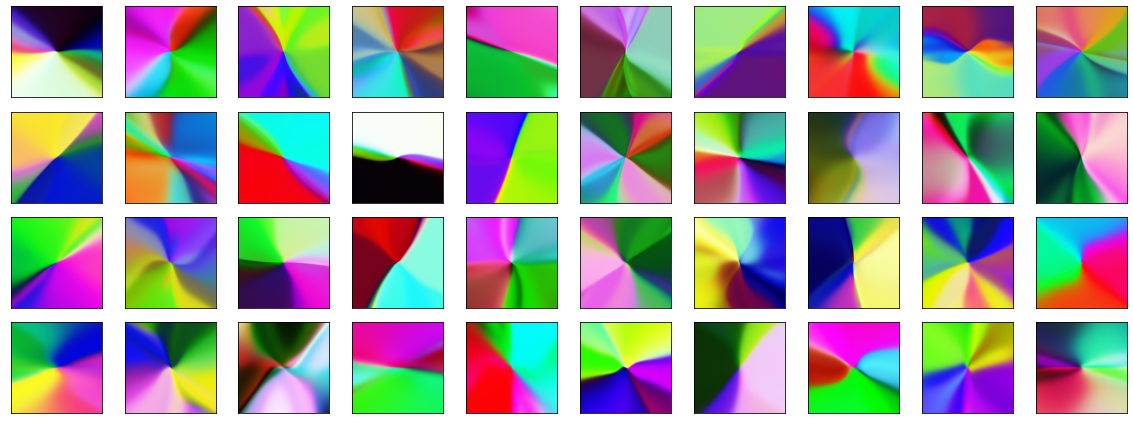

In [80]:
generate_one_gallery({"num_hidden_layers":4, "num_neurons":8, "include_bias":False})

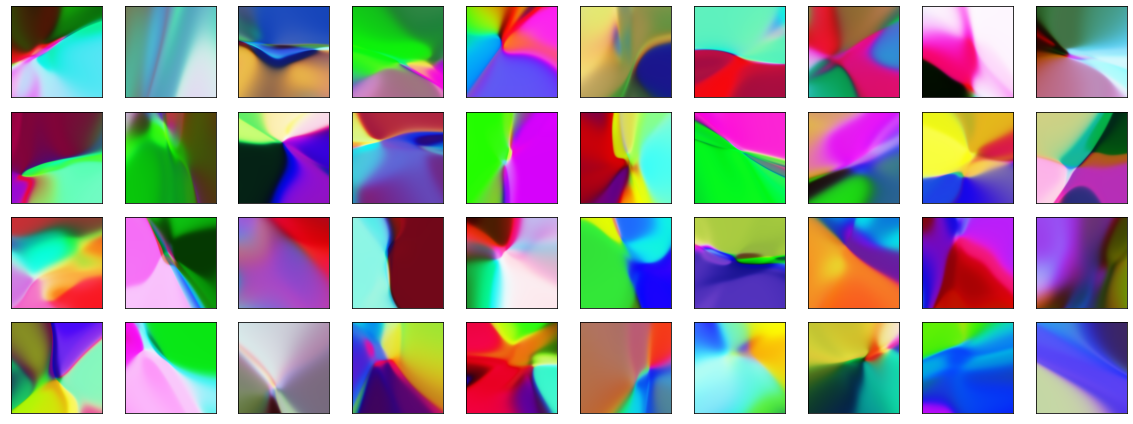

In [81]:
generate_one_gallery({"num_hidden_layers":4, "num_neurons":8, "include_bias":True})

Without bias, the images are always at the center! Adding bias to input adds variety, keeping it.

## Distance to origin

CPPNs as first proposed by Kenneth Stanley takes into account input of distance from origin to provide the network with radial information.

In [82]:
class Net(nn.Module):
    """
    Input
    -----
    Normalized (x, y), ranging from -1 to 1
    Output: RGB color at that point.
    """
    def __init__(self, num_hidden_layers=4, num_neurons=8, include_bias=True, include_dist_to_origin=False):
        """
        Inputs
        ------
        num_hidden_layers: int
        num_neurons: int
        include_bias: bool
        include_dist_to_origin: bool
        """
        super(Net, self).__init__()
        
        # Input layer
        if include_dist_to_origin:
            layers = [nn.Linear(3, num_neurons, bias=include_bias), nn.Tanh()]
        else:
            layers = [nn.Linear(2, num_neurons, bias=include_bias), nn.Tanh()]
        
        # Hidden layers
        layers.extend(num_hidden_layers * [nn.Linear(num_neurons, num_neurons, bias=False), nn.Tanh(),])
            
        # Output layer
        layers.extend([nn.Linear(num_neurons, 3, bias=False), nn.Sigmoid()])
        
        # Assign layers to self.layers
        self.layers = nn.Sequential(*layers)
        
        # Run weight init
        self.init_weights()
        
    def forward(self, x):
        x = self.layers(x)
        return x
    
    def _init_weights(self, m):
        """
        Ref: https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
        """
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, mean=0, std=1)
            
    def init_weights(self):
        self.apply(self._init_weights)

In [83]:
def create_input(img_width, img_height, include_dist_to_origin=False):
    """
    Creates the input for the generative net. 
    Outputs numpy array w/ shape (img_width * img_height, 2)
    
    Input
    -----
    img_width, img_height: int
    include_dist_to_origin: bool
    """
    # Create vectors of xs and ys   
    xs = np.linspace(start=-1, stop=1, num=img_width)
    ys = np.linspace(start=-1, stop=1, num=img_height)
    
    # Use np.meshgrid to create a mesh grid
    xv, yv = np.meshgrid(xs, ys)
    input_arr = np.stack((xv, yv), axis=2)
    
    if include_dist_to_origin:
        dist_to_origin = np.sum(np.square(input_arr), axis=2, keepdims=True)
        input_arr = np.concatenate([input_arr, dist_to_origin], axis=2)
        input_arr = input_arr.reshape(img_width * img_height, 3)
    else:
        input_arr = input_arr.reshape(img_width * img_height, 2)
    
    return input_arr

Toggling off the bias, just to be able to compare the impact of incorporating distance to origin.

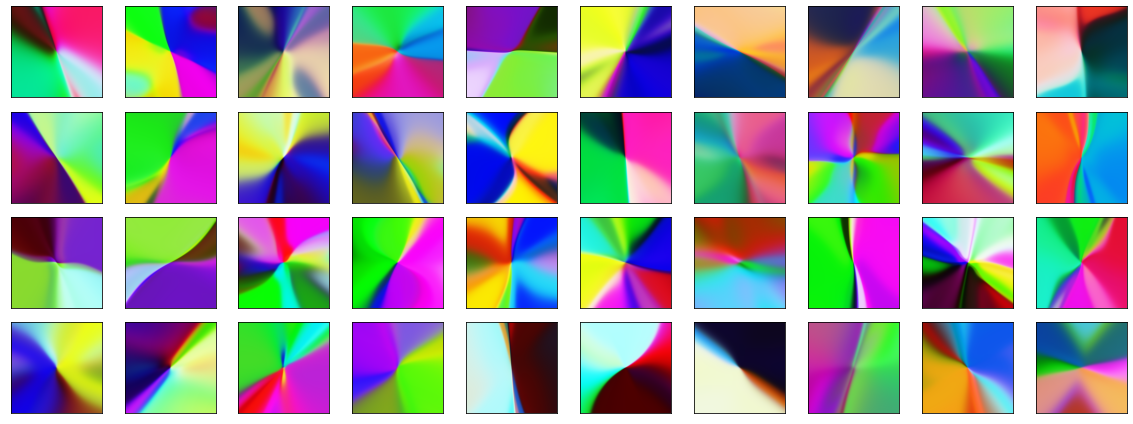

In [84]:
generate_one_gallery(
    net_config={"num_hidden_layers":4, "num_neurons":8, "include_bias":False, "include_dist_to_origin": False},
    input_config={"img_width": 320, "img_height": 320, "include_dist_to_origin": False}
)

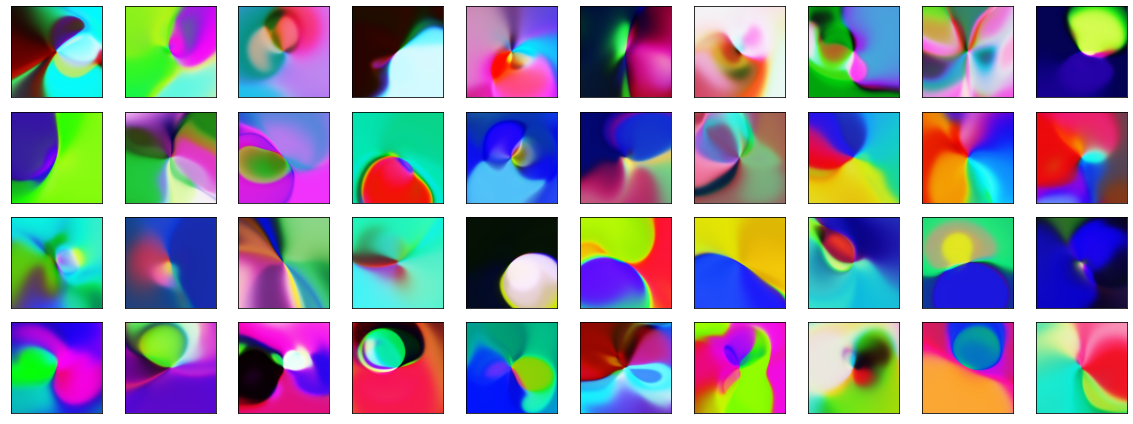

In [85]:
generate_one_gallery(
    net_config={"num_hidden_layers":4, "num_neurons":8, "include_bias":False, "include_dist_to_origin": True},
    input_config={"img_width": 320, "img_height": 320, "include_dist_to_origin": True}
)

Was expecting to see purely radial patterns, wasn't expecting to see elliptical regions emerge in the image.

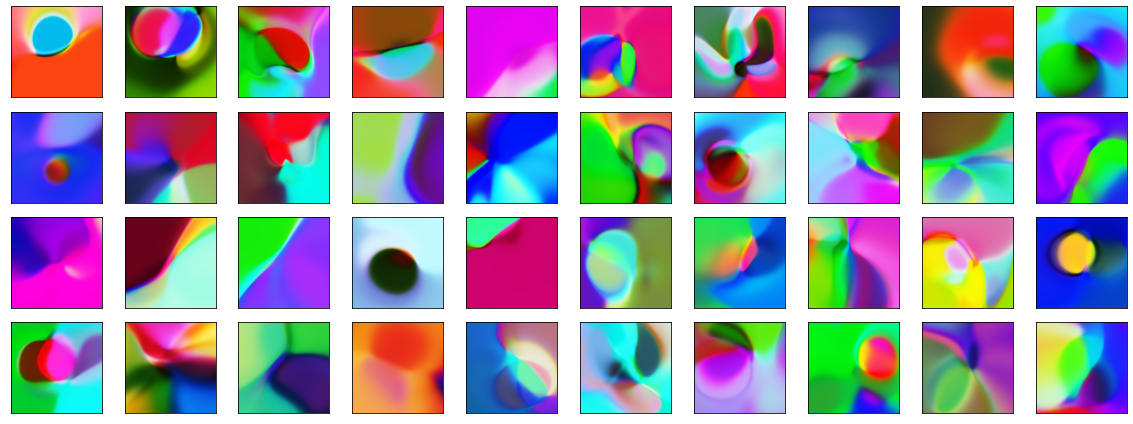

In [87]:
generate_one_gallery(
    net_config={"num_hidden_layers":4, "num_neurons":8, "include_bias": True, "include_dist_to_origin": True},
    input_config={"img_width": 320, "img_height": 320, "include_dist_to_origin": True}
)

Adding the bias doesn't have a noticeable effect on the resultant ellipses. Not a fan of the ellipses as they make the images less interesting. Perhaps this is dependent on image size.

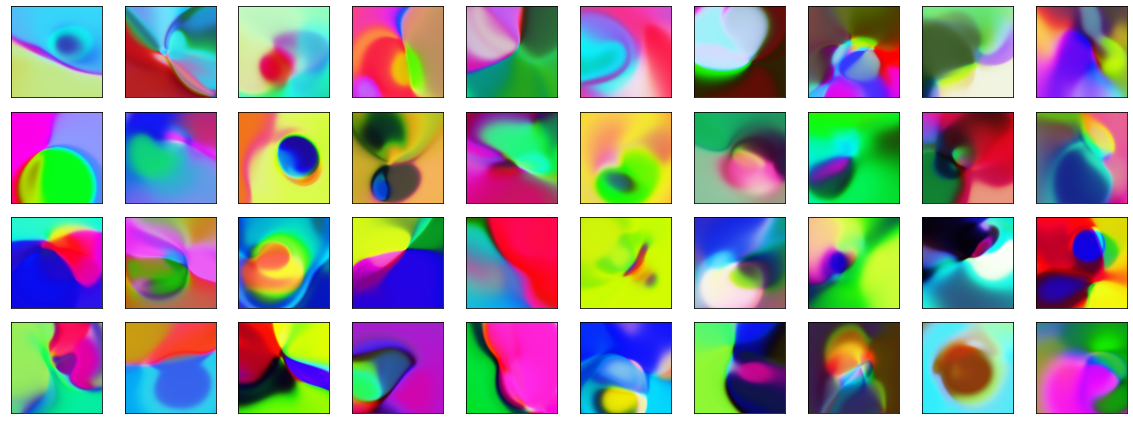

In [88]:
generate_one_gallery(
    net_config={"num_hidden_layers":4, "num_neurons":8, "include_bias": True, "include_dist_to_origin": True},
    input_config={"img_width": 640, "img_height": 640, "include_dist_to_origin": True}
)

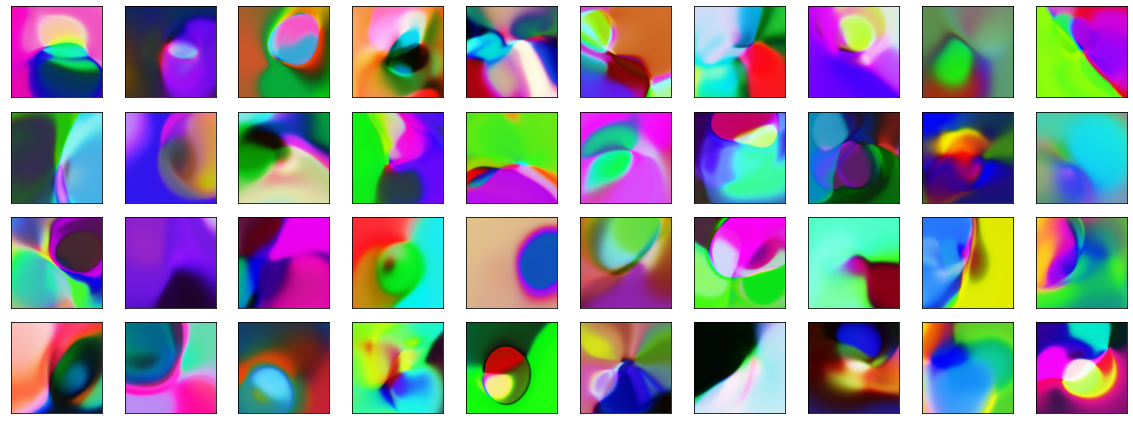

In [89]:
generate_one_gallery(
    net_config={"num_hidden_layers":4, "num_neurons":8, "include_bias": True, "include_dist_to_origin": True},
    input_config={"img_width": 1280, "img_height": 1280, "include_dist_to_origin": True}
)

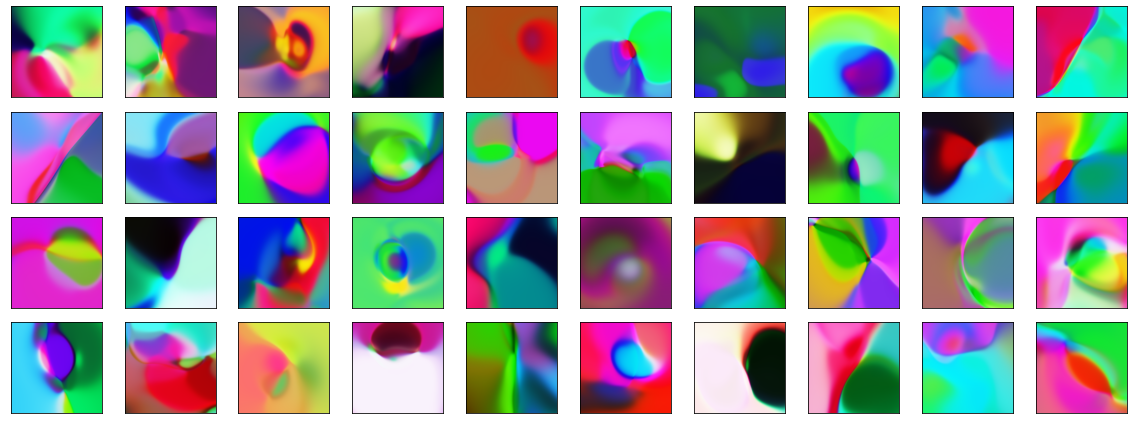

In [90]:
generate_one_gallery(
    net_config={"num_hidden_layers":4, "num_neurons":8, "include_bias": True, "include_dist_to_origin": True},
    input_config={"img_width": 160, "img_height": 160, "include_dist_to_origin": True}
)

Having tried 640x640, 1280x1280 and 160x160 above, don't think it's related to image size. 

Ellipses that are small enough to fit in frame are not my taste, but I quite like the images that make interesting use of the curvature. 

Either way, leaving this in as an option.

## Latent vector

Was thinking about finding a means to traverse the latent space of the model weights to generate a smoothly varying image. Went down a rabbit hole trying to vary the weights meaningfully between generated output images. The article author thought about this, and decided to directly supply a latent vector as input, with the goal of being able to use it to provide semantic information for more practical generative use cases. Why didn't I think of that?

Note: Redefining all functions used below.

In [132]:
class Net(nn.Module):
    """
    Input
    -----
    Normalized (x, y), ranging from -1 to 1
    Output: RGB color at that point.
    """
    def __init__(self, num_hidden_layers=4, num_neurons=8, latent_len=3, include_bias=True, include_dist_to_origin=False):
        """
        Inputs
        ------
        num_hidden_layers: int
        num_neurons: int
        latent_len: int
        include_bias: bool
        include_dist_to_origin: bool
        """
        super(Net, self).__init__()
        
        # Input layer
        if include_dist_to_origin:
            layers = [nn.Linear(3 + latent_len, num_neurons, bias=include_bias), nn.Tanh()]
        else:
            layers = [nn.Linear(2 + latent_len, num_neurons, bias=include_bias), nn.Tanh()]
        
        # Hidden layers
        layers.extend(num_hidden_layers * [nn.Linear(num_neurons, num_neurons, bias=False), nn.Tanh(),])
            
        # Output layer
        layers.extend([nn.Linear(num_neurons, 3, bias=False), nn.Sigmoid()])
        
        # Assign layers to self.layers
        self.layers = nn.Sequential(*layers)
        
        # Run weight init
        self.init_weights()
        
    def forward(self, loc_vec, latent_vec):
        """
        Note: Both loc_vec and latent_vec need to be torch.Tensors
        """
        x = torch.cat([loc_vec, latent_vec], dim=1)
        x = self.layers(x)
        return x
    
    def _init_weights(self, m):
        """
        Ref: https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
        """
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, mean=0, std=1)
            
    def init_weights(self):
        self.apply(self._init_weights)

In [97]:
def create_input(img_width, img_height, include_dist_to_origin=False):
    """
    Creates the input for the generative net. 
    Outputs numpy array w/ shape (img_width * img_height, 2)
    
    Input
    -----
    img_width, img_height: int
    include_dist_to_origin: bool
    """
    # Create vectors of xs and ys   
    xs = np.linspace(start=-1, stop=1, num=img_width)
    ys = np.linspace(start=-1, stop=1, num=img_height)
    
    # Use np.meshgrid to create a mesh grid
    xv, yv = np.meshgrid(xs, ys)
    input_arr = np.stack((xv, yv), axis=2)
    
    if include_dist_to_origin:
        dist_to_origin = np.sum(np.square(input_arr), axis=2, keepdims=True)
        input_arr = np.concatenate([input_arr, dist_to_origin], axis=2)
        input_arr = input_arr.reshape(img_width * img_height, 3)
    else:
        input_arr = input_arr.reshape(img_width * img_height, 2)
    
    return input_arr

In [123]:
def generate_one_art(net, latent_vec, input_config={"img_width":320, "img_height":320}):
    # Create input to net, and convert from ndarray to torch.FloatTensor
    net_input = torch.tensor(create_input(**input_config)).float()
    
    # Create input array from latent_vec, and convert from ndarray to torch.FloatTensor
    latent_vec = np.expand_dims(latent_vec, axis=0)
    latent_vec = np.repeat(latent_vec, repeats=net_input.shape[0], axis=0)
    latent_vec = torch.tensor(latent_vec).float()
    
    assert net_input.shape == latent_vec.shape
    
    # Run input through net
    net_output = net(net_input, latent_vec).detach().numpy()
    
    # Reshape into (x, y, 3) for plotting
    net_output = net_output.reshape(input_config["img_width"], input_config["img_width"], 3)
    
    # Re-format to color output
    # Scale to range 0 to 255, and set type to int
    net_output = (net_output * 255).astype(np.uint8)
    return net_output

In [151]:
def generate_one_gallery(
    net_config={"num_hidden_layers":4, "num_neurons":8, "include_bias":True},
    input_config={"img_width":320, "img_height":320},
    ):
    """
    Generate grid of 40 images, accepting net_config as dict containing parameters to Net constructor
    From these images, the ones in a column are the same network but have their latent vector perturbed.
    """
    fig, ax = plt.subplots(ncols=10, nrows=4, figsize=(16, 6))
    
    for i in range(10):
        net = Net(**net_config)
        latent_vec = np.random.normal(size=(3, ))
        
        for j in range(4):
            out = generate_one_art(net, latent_vec=latent_vec, input_config=input_config)
            latent_vec += 0.2
            img = Image.fromarray(out)
            ax[j, i].imshow(img)
            ax[j, i].xaxis.set_visible(False)
            ax[j, i].yaxis.set_visible(False)
            
    plt.tight_layout()
    plt.show()

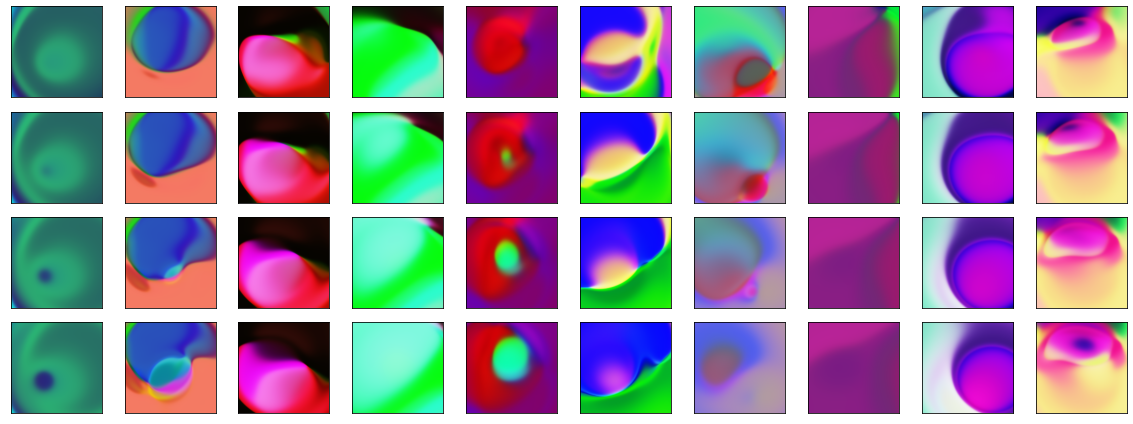

In [152]:
generate_one_gallery(
    net_config={"num_hidden_layers":4, "num_neurons":8, "latent_len": 3, "include_bias": True, "include_dist_to_origin": True},
    input_config={"img_width": 160, "img_height": 160, "include_dist_to_origin": True}
)

This is entertaining.

## Adding toggle for grayscale

One more thing to add is an option to toggle grayscale output.

In [5]:
class Net(nn.Module):
    def __init__(self, num_hidden_layers=4, num_neurons=8, latent_len=3, include_bias=True, include_dist_to_origin=True, rgb=True):
        """
        Inputs
        ------
        num_hidden_layers: int
        num_neurons: int
        latent_len: int
        include_bias: bool
        include_dist_to_origin: bool
        rgb: bool
        """
        super(Net, self).__init__()
        
        # Input layer
        if include_dist_to_origin:
            layers = [nn.Linear(3 + latent_len, num_neurons, bias=include_bias), nn.Tanh()]
        else:
            layers = [nn.Linear(2 + latent_len, num_neurons, bias=include_bias), nn.Tanh()]
        
        # Hidden layers
        layers.extend(num_hidden_layers * [nn.Linear(num_neurons, num_neurons, bias=False), nn.Tanh(),])
            
        # Output layer
        if rgb:
            layers.extend([nn.Linear(num_neurons, 3, bias=False), nn.Sigmoid()])
        else:
            layers.extend([nn.Linear(num_neurons, 1, bias=False), nn.Sigmoid()])
        
        # Assign layers to self.layers
        self.layers = nn.Sequential(*layers)
        
        # Run weight init
        self.init_weights()
        
    def forward(self, loc_vec, latent_vec):
        """
        Note: Both loc_vec and latent_vec need to be torch.Tensors
        """
        x = torch.cat([loc_vec, latent_vec], dim=1)
        x = self.layers(x)
        return x
    
    def _init_weights(self, m):
        """
        Ref: https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
        """
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, mean=0, std=1)
            
    def init_weights(self):
        self.apply(self._init_weights)

In [6]:
def create_input(img_width, img_height, include_dist_to_origin=True):
    """
    Creates the input for the generative net. 
    Outputs numpy array w/ shape (img_width * img_height, 2)
    
    Input
    -----
    img_width, img_height: int
    include_dist_to_origin: bool
    """
    # Create vectors of xs and ys   
    xs = np.linspace(start=-1, stop=1, num=img_width)
    ys = np.linspace(start=-1, stop=1, num=img_height)
    
    # Use np.meshgrid to create a mesh grid
    xv, yv = np.meshgrid(xs, ys)
    input_arr = np.stack((xv, yv), axis=2)
    
    if include_dist_to_origin:
        dist_to_origin = np.sum(np.square(input_arr), axis=2, keepdims=True)
        input_arr = np.concatenate([input_arr, dist_to_origin], axis=2)
        input_arr = input_arr.reshape(img_width * img_height, 3)
    else:
        input_arr = input_arr.reshape(img_width * img_height, 2)
    
    return input_arr

In [7]:
def generate_one_art(net, latent_vec, input_config={"img_width":320, "img_height":320}):
    # Create input to net, and convert from ndarray to torch.FloatTensor
    net_input = torch.tensor(create_input(**input_config)).float()
    
    # Create input array from latent_vec, and convert from ndarray to torch.FloatTensor
    latent_vec = np.expand_dims(latent_vec, axis=0)
    latent_vec = np.repeat(latent_vec, repeats=net_input.shape[0], axis=0)
    latent_vec = torch.tensor(latent_vec).float()
    
    assert net_input.shape == latent_vec.shape
    
    # Run input through net
    net_output = net(net_input, latent_vec).detach().numpy()
    
    # Reshape into (y, x, 3) for plotting in PIL
    net_output = net_output.reshape(input_config["img_height"], input_config["img_width"], -1)
    
    # Re-format to color output
    # Scale to range 0 to 255, and set type to int
    net_output = (net_output * 255).astype(np.uint8)
    return net_output

In [8]:
def generate_one_gallery(
    net_config={"num_hidden_layers":4, "num_neurons":8, "include_bias":True},
    input_config={"img_width":320, "img_height":320},
    ):
    """
    Generate grid of 40 images, accepting net_config as dict containing parameters to Net constructor
    From these images, the ones in a column are the same network but have their latent vector perturbed.
    """
    fig, ax = plt.subplots(ncols=10, nrows=4, figsize=(16, 6))
    
    for i in range(10):
        net = Net(**net_config)
        latent_vec = np.random.normal(size=(3, ))
        
        for j in range(4):
            out = generate_one_art(net, latent_vec=latent_vec, input_config=input_config)
            latent_vec += 0.2
            
            # if (n, n, 1) output i.e. if grayscale
            if out.shape[2] == 1:
                img = Image.fromarray(np.squeeze(out), mode="L") # Mode inference is automatic but better be explicit
                ax[j, i].imshow(img, cmap="gray")
            else:
                img = Image.fromarray(out, mode="RGB")
                ax[j, i].imshow(img, cmap="gray")
            
            ax[j, i].xaxis.set_visible(False)
            ax[j, i].yaxis.set_visible(False)
            
    plt.tight_layout()
    plt.show()

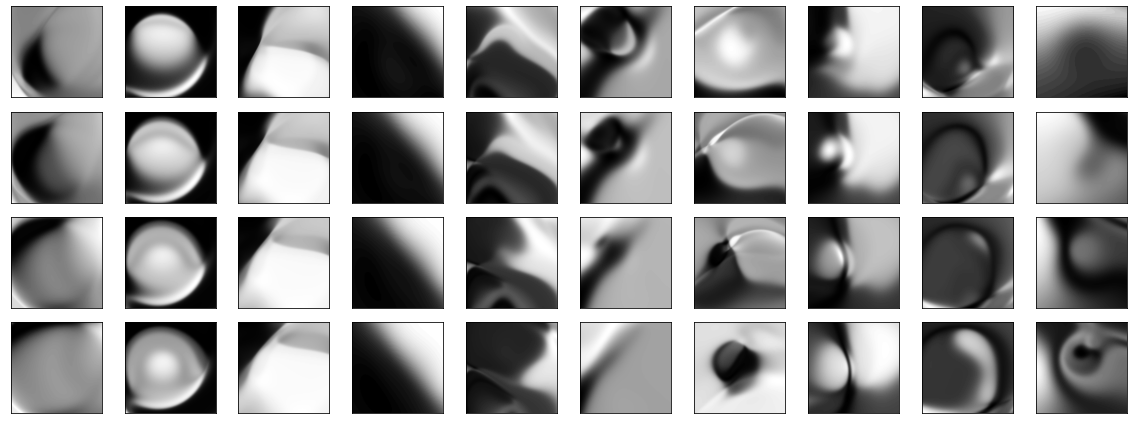

In [9]:
generate_one_gallery(
    net_config={"num_hidden_layers":4, "num_neurons":8, "latent_len": 3, "include_bias": True, "include_dist_to_origin": True, "rgb": False},
    input_config={"img_width": 160, "img_height": 160, "include_dist_to_origin": True}
)

Black and white images generated seem a bit spooky compared to the RGB images.

## Interactive demo

Cobbling together a little interactive demo to make it easier to play around with the settings. Fixed a few configs, more interested in tweaking with the number of hidden layers, number of neurons, and also the latent vector.

In [10]:
import ipywidgets as ipy

In [11]:
def gen_demo(
    seed=None,
    num_hidden_layers=4, num_neurons=8,
    latent1=0, latent2=0, latent3=0
):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    net = Net(num_hidden_layers=num_hidden_layers, num_neurons=num_neurons)
    latent_vec = [latent1, latent2, latent3]
    out = generate_one_art(net, latent_vec=latent_vec, input_config={"img_width": 640, "img_height": 320}) # limited screen real estate ¯\_(ツ)_/¯
    
    img = Image.fromarray(out, mode="RGB")
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.imshow(img, cmap="gray")

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.show()

In [14]:
ipy.interact(
    gen_demo,
    seed=ipy.BoundedIntText(value=0, min=0, max=10000000, description="Set random seed", continuous_update=False),
    num_hidden_layers=ipy.IntSlider(min=2, max=64, step=2, value=4, continuous_update=False),
    num_neurons=ipy.IntSlider(min=2, max=64, step=2, value=8, continuous_update=False),
    latent1=ipy.FloatSlider(min=-3, max=3, step=0.1, value=0, continuous_update=False),
    latent2=ipy.FloatSlider(min=-3, max=3, step=0.1, value=0, continuous_update=False),
    latent3=ipy.FloatSlider(min=-3, max=3, step=0.1, value=0, continuous_update=False),
)

interactive(children=(BoundedIntText(value=0, description='Set random seed', max=10000000), IntSlider(value=4,…

<function __main__.gen_demo(seed=None, num_hidden_layers=4, num_neurons=8, latent1=0, latent2=0, latent3=0)>

Few observations:
+ Increasing `num_neurons` at every layer makes the colours more extreme. Seeing patches of RGB, black and white.
+ When `num_neurons` are small (10 and below), increasing `num_hidden_layers` doesn't have an effect on the image. At 12 and above it becomes a cacophony of patterns, mixed in with some snowcrash. Once this point is reached, increasing either num hidden layers or num neurons further brings on more and more [snowcrash](https://en.wikipedia.org/wiki/Snow_Crash) until the whole image is saturated with it.
+ When `num_hidden_layers` are very small, increasing `num_neurons` gives a wonderfully abstract composition of images. Images are very responsive to change in latent vector at this stage. 2 hidden layers with 64 neurons looks rather ideal. Increasing `num_hidden_layers` further splits up colourful regions in the image into increasingly fragmented shards, until the shards themselves give way to snowcrash.
+ Having too little layers and neurons give a simple image of colour gradients that is quite blurred and unfocused, when both is at (8, 8) is where complex patterns begin to emerge. 
+ As a ground rule, having more hidden layers than neurons leads to images that have sharp colours between blotches of colour, and don't look sufficiently artistic for my taste.

Interesting settings for `(num_hidden_layers, num_neurons)`
+ (2, 64)
+ (8, 12)
+ (6, 22)